# Dipoles visualization

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from mybigdft import Logfile

conn = sqlite3.connect("../results.db")
c = conn.cursor()

In [2]:
# Set parameters for matplotlib
plt.rcParams.update({'font.size': 14})
colors = ['#d73027', '#f46d43', '#aaaaaa', '#66bd63', '#1a9850']

## Define some global variables

These variables store all the relevant data to be used in the following.

In [3]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Turn-on all warnings into errors
np.seterr(all="raise")

# Connect to the database and define a cursor
conn = sqlite3.connect('results.db')
c = conn.cursor()

In [4]:
# Set parameters for matplotlib
plt.rcParams.update({'font.size': 14})
colors = ['#d73027', '#f46d43', '#aaaaaa', '#66bd63', '#1a9850']

In [5]:
# Get all the relevant data
MOLECULES = [name for (name,) in c.execute("""SELECT name FROM molecule""").fetchall()]
HGRIDS = [value for (value,) in c.execute("""SELECT value FROM hgrid""").fetchall()][::-1]
RMULTS = c.execute("""SELECT frmult, crmult FROM rmult""").fetchall()
nb_notebooks = c.execute("SELECT COUNT(*) FROM notebook").fetchall()[0][0]
xmax = nb_notebooks // len(MOLECULES)

In [6]:
# Be sure to run the post_processing.ipynb notebook to make sure the
# converged_param table is in the database.
data = c.execute("""SELECT * FROM converged_param""").fetchall()
CONVERGED_PARAMS = {
    name: {"hgrids": hg, "rmult": [frm, crm]}
    for (name, hg, frm, crm) in data
}
# Looking at the convergence data, one suspects that the correct
# values for hgrids should be 0.38 for the CH4 molecule
CONVERGED_PARAMS["CH4"]["hgrids"] = 0.38

## Dipole convergence for each molecule

In each plot below, which focuses on one particular molecule, each dipole is represented by one point. A given column accounts for the dipole found for one particular set of input parameters. The five first columns represent the dipoles for the highest hgrid, sorted by increasing rmult from left to right. It goes on like this by packet of five columns until the last five columns, which represent the dipoles for the lowest hgrid. The rightmost column represents the most converged dipole: it corresponds to the computation with the smallest grid-step (hgrid) and the largest grid extension (rmult).

In [7]:
try:
    # Put all the relevant BigDFT data in a single temprary table
    c.execute("CREATE TEMP TABLE dipoles AS "
              "SELECT n.id, n.hgrid, d.value, n.molecule, n.crmult, n.frmult "
              "FROM dipole d "
              "JOIN notebook n ON n.id = d.id_notebook ")
except sqlite3.OperationalError:
    pass

In [8]:
def plot_dipoles(name, only_converged=False):
    """
    Plot the dipole of a given molecule. You can specifically
    filter the dipole by selecting those coming from converged
    calculations ("converged" in the sense that the input
    parameters used to get these optimized positions were such
    that the precision per atom on the total energy of the system
    is below the desired value of 1 meV). The default is to use all
    the values, whether they can be considered as converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    only_converged : bool
        If `True`, then only the dipoles coming from converged
        calculations are plotted.
    """
    # Set the plot
    plt.figure(figsize=(6,4.5))
    # Set the value of the converged parameters
    if only_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
        suffix = " (only converged)"
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
        suffix = ""
    # Loop over the RMULTS to gather the dipoles
    for i, (frm, crm) in enumerate(RMULTS):
        if frm >= frm_min and crm >= crm_min:
            if "F" in name:
                # Filter out the larger hgrids
                c.execute(
                    "SELECT id, hgrid, value "
                    "FROM dipoles "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND hgrid <= ?"
                    "      AND hgrid <= 0.35 ",
                    (name, crm, frm, hg_max)
                )
            else:
                c.execute(
                    "SELECT id, hgrid, value "
                    "FROM dipoles "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND hgrid <= ?",
                    (name, crm, frm, hg_max)
                )
        results = c.fetchall()
        x = [(id_nb - 1) // len(MOLECULES) for (id_nb, _, _) in results]
        dipoles = [dipole for (_, _, dipole) in results]
        label = f"Grid extension = [{frm}, {crm}]"
        plt.scatter(x, dipoles, label=label, c=colors[i%len(RMULTS)])
    # Plot vertical lines
    locs = [x * len(RMULTS) + len(RMULTS) - 0.5 for x in range(len(HGRIDS)-1)]
    ylim = plt.ylim()
    plt.vlines(locs, *ylim, linewidth=1)
    # Set x RMULTS
    locs = [x * len(RMULTS) + len(RMULTS) / 2 -0.5 for x in range(len(HGRIDS))]
    labels = [hg for hg in HGRIDS]
    plt.xticks(locs, labels)
    # Finalize plot
    plt.xlabel("Grid step")
    plt.ylabel(r"Dipoles [AU]")
    plt.xlim(-1, xmax)
    plt.title(name+suffix)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.show()

In [9]:
def dipoles_stats(name, only_converged=False,
                  only_not_converged=False, verbosity=True):
    """
    Find the mean value and the standard deviation of the dipole
    for a given molecule. You must specifically filter the dipoles
    coming from converged or not converged geometries ("converged"
    in the sense that the input parameters used to get these
    optimized positions were such that the precision per atom on the
    total energy of the system is below the desired value of 1 meV).
    The default is to use all the values, whether they can be
    considered as converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    only_converged : bool
        If `True`, then only the dipoles coming from converged
        calculations are used to define the stats.
    only_not_converged : bool
        If `True`, then only the dipoles coming from non-converged
        calculations are used to define the stats.
    """
    # Set the value of the converged parameters
    if only_converged or only_not_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
    # Gather the dipoles
    dipoles = []
    if only_not_converged:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT value "
                "FROM dipoles "
                "WHERE molecule = ? "  # dipoles from the desired molecule
                "      AND hgrid <= 0.35 "  # hgrid not too large when F atom(s) in the molecule
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?)",  # dipoles coming from non-converged notebooks
                (name, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT value "
                "FROM dipoles "
                "WHERE molecule = ? "
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?)",
                (name, hg_max, frm_min, crm_min)
            )
    else:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT value "
                "FROM dipoles "
                "WHERE molecule = ? "
                "      AND hgrid <= 0.35 "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ?",  # dipoles coming from all or converged notebooks
                (name, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT value "
                "FROM dipoles "
                "WHERE molecule = ? "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ?",
                (name, hg_max, frm_min, crm_min)
            )
    dipoles += [dipole for (dipole,) in c.fetchall()]
    try:
        mean = np.mean(dipoles)
        std_dev = np.std(dipoles)
        results = f"mean = {mean:1.7f} AU; std. dev. = {std_dev:.2e} AU; std. dev / mean = {std_dev / mean:.3e}"
        if verbosity:
            print(name, results)
    except (FloatingPointError, RuntimeWarning):
        mean = None
        std_dev = None
        if verbosity:
            print("Cannot compute quanitites")
    return mean, std_dev

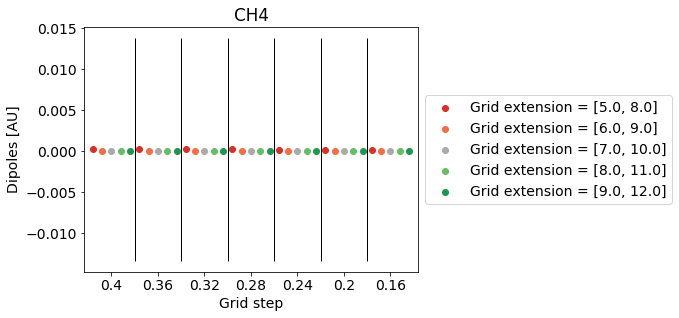

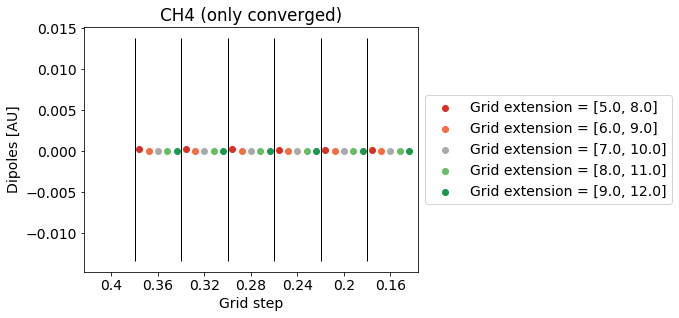

CH4 mean = 0.0000457 AU; std. dev. = 8.14e-05 AU; std. dev / mean = 1.783e+00
CH4 mean = 0.0000686 AU; std. dev. = 1.16e-04 AU; std. dev / mean = 1.698e+00


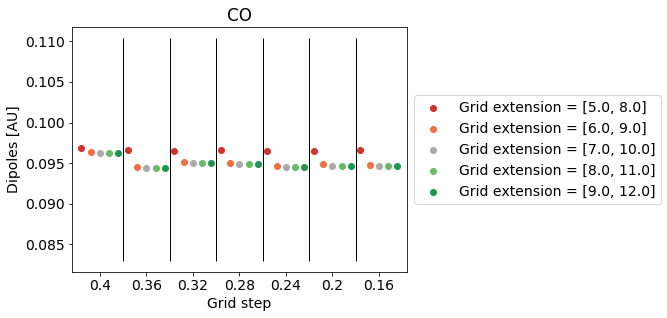

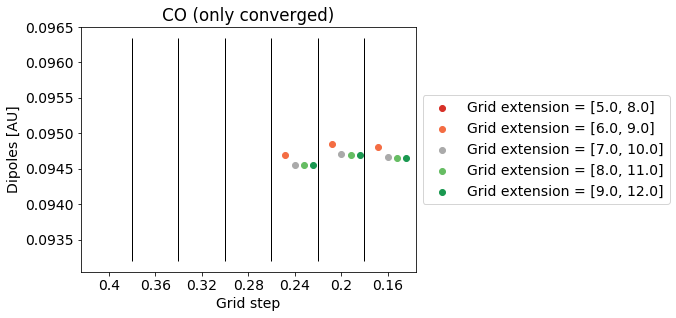

CO mean = 0.0946745 AU; std. dev. = 8.87e-05 AU; std. dev / mean = 9.374e-04
CO mean = 0.0956275 AU; std. dev. = 8.69e-04 AU; std. dev / mean = 9.087e-03


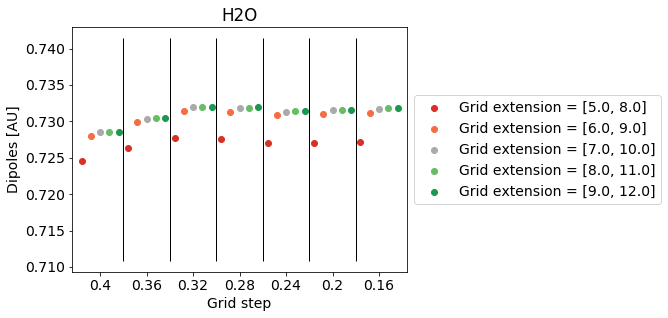

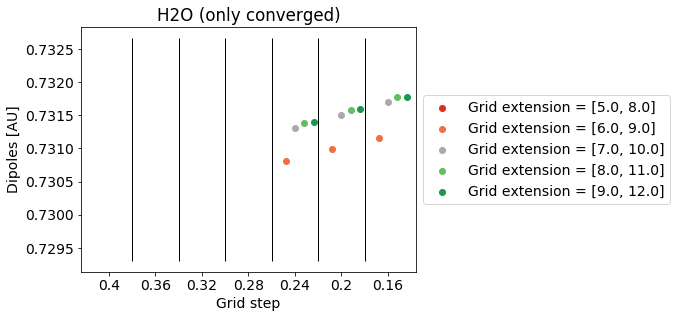

H2O mean = 0.7314158 AU; std. dev. = 2.93e-04 AU; std. dev / mean = 4.007e-04
H2O mean = 0.7294196 AU; std. dev. = 2.18e-03 AU; std. dev / mean = 2.982e-03


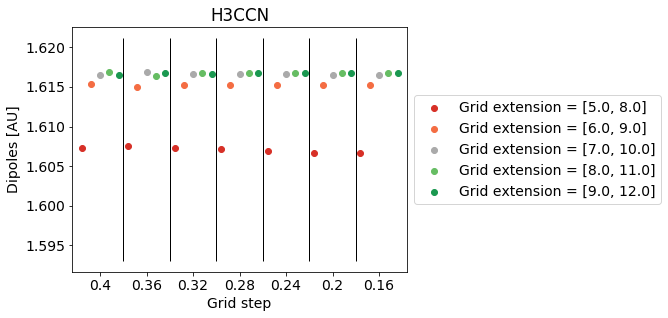

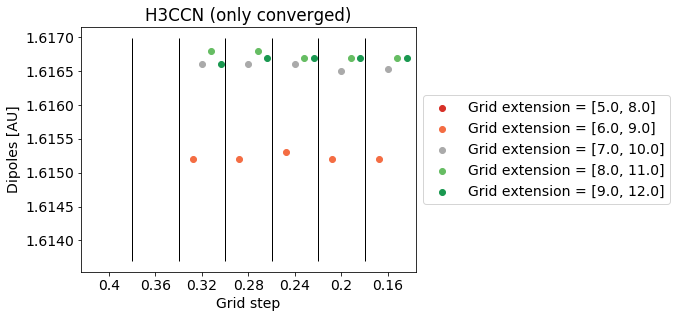

H3CCN mean = 1.6163018 AU; std. dev. = 6.29e-04 AU; std. dev / mean = 3.892e-04
H3CCN mean = 1.6120002 AU; std. dev. = 4.63e-03 AU; std. dev / mean = 2.871e-03


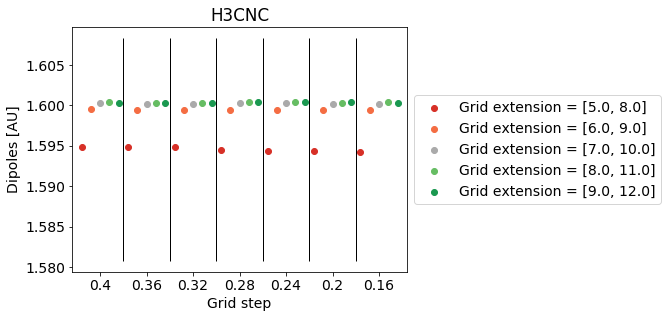

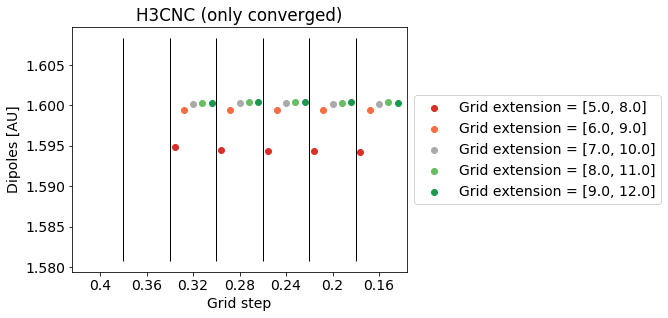

H3CNC mean = 1.5989865 AU; std. dev. = 2.28e-03 AU; std. dev / mean = 1.425e-03
H3CNC mean = 1.5990504 AU; std. dev. = 2.15e-03 AU; std. dev / mean = 1.342e-03


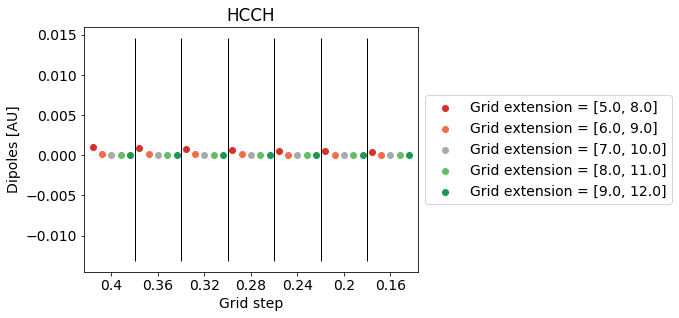

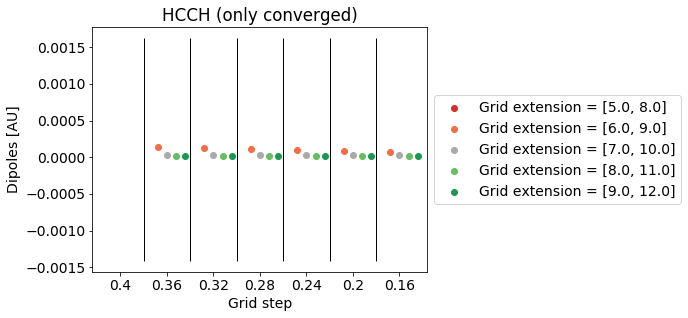

HCCH mean = 0.0000432 AU; std. dev. = 3.84e-05 AU; std. dev / mean = 8.880e-01
HCCH mean = 0.0004681 AU; std. dev. = 3.54e-04 AU; std. dev / mean = 7.569e-01


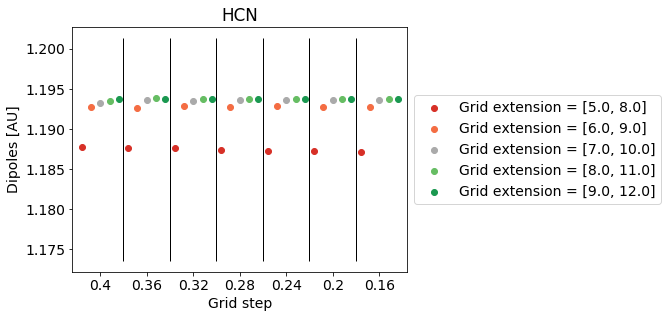

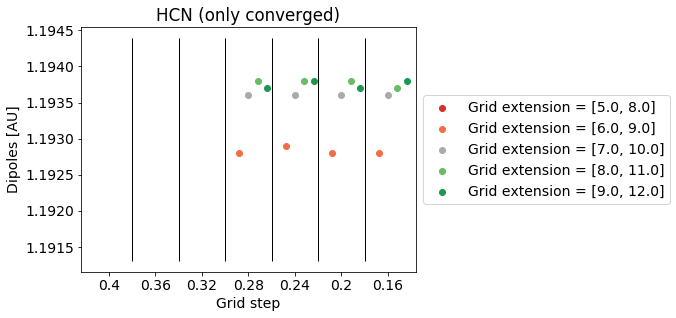

HCN mean = 1.1934875 AU; std. dev. = 3.90e-04 AU; std. dev / mean = 3.270e-04
HCN mean = 1.1912158 AU; std. dev. = 2.92e-03 AU; std. dev / mean = 2.447e-03


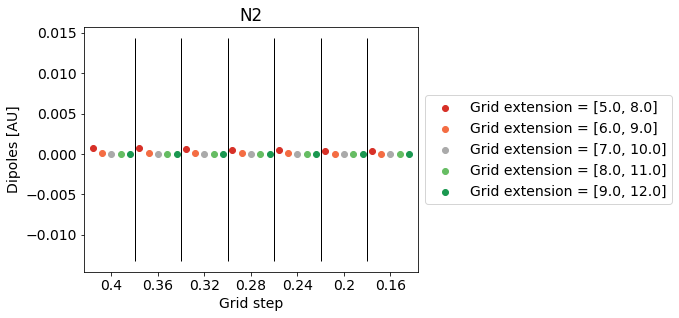

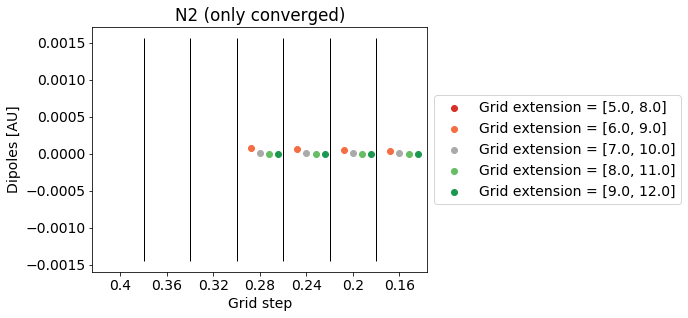

N2 mean = 0.0000162 AU; std. dev. = 2.44e-05 AU; std. dev / mean = 1.504e+00
N2 mean = 0.0002217 AU; std. dev. = 2.71e-04 AU; std. dev / mean = 1.222e+00


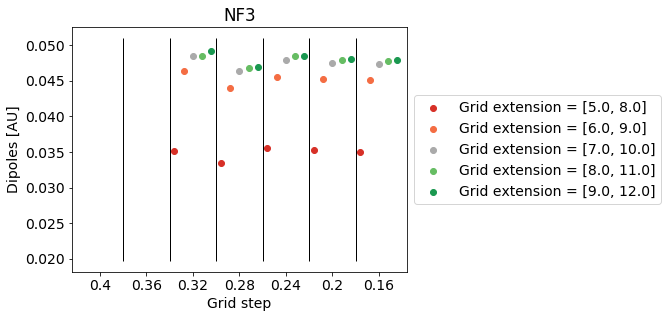

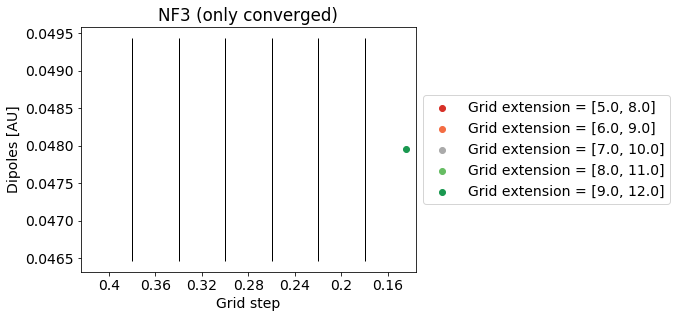

NF3 mean = 0.0479520 AU; std. dev. = 0.00e+00 AU; std. dev / mean = 0.000e+00
NF3 mean = 0.0446295 AU; std. dev. = 5.16e-03 AU; std. dev / mean = 1.156e-01


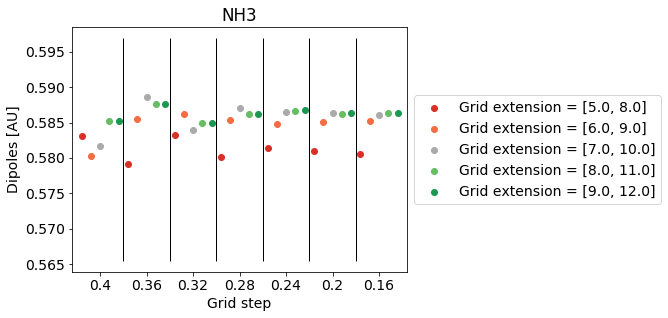

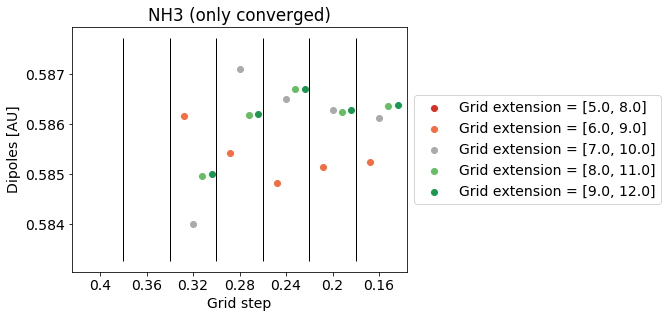

NH3 mean = 0.5858955 AU; std. dev. = 7.73e-04 AU; std. dev / mean = 1.320e-03
NH3 mean = 0.5833487 AU; std. dev. = 2.97e-03 AU; std. dev / mean = 5.088e-03


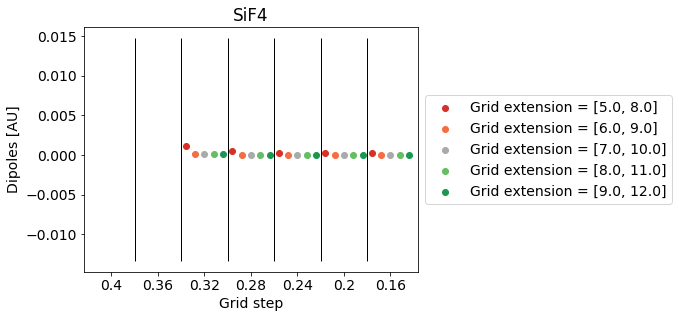

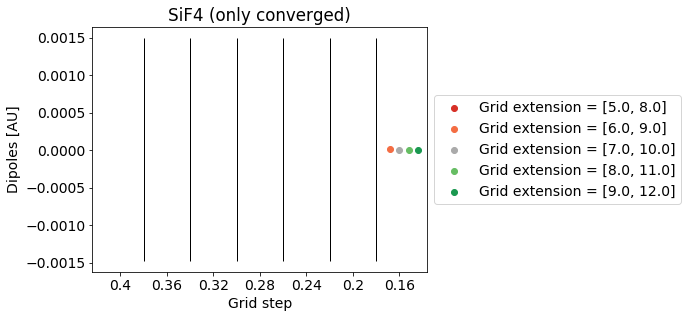

SiF4 mean = 0.0000041 AU; std. dev. = 3.43e-06 AU; std. dev / mean = 8.319e-01
SiF4 mean = 0.0001416 AU; std. dev. = 2.63e-04 AU; std. dev / mean = 1.858e+00


In [10]:
for name in MOLECULES:
    plot_dipoles(name)
    plot_dipoles(name, only_converged=True)
    dipoles_stats(name, only_converged=True)
    dipoles_stats(name, only_not_converged=True)

## Precision on the dipole

The output of the above cell shows that statistics such as the mean value and the standard deviation of each dipole can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged dipoles. Let us see how all these values can be used to assess the expected precision on the dipole. This precision should be linked to the precision per atom on the total energy is around 1 meV (or ~ 8 cm$^{-1}$): increasing or decreasing that value should have a similar effect on the errors on the dipole (but that won't be studied).

In order to do that, we need to gather the mean dipole and the standard deviation for each dipole. This is done in the following cell, discriminating the data coming from converged and not converged calculations.

In [11]:
# The stats obtained along with the above plots are stored in the
# following dictionary, which has the molcule names as key. Stats for
# both converged and non-converged stats are computed, except for some
# cases defined above (where the non-converged results cannot be computed).
stats = {}
# Loop over the molecules
for name in MOLECULES:
    stats[name] = {"converged": None, "not_converged": None}
    # Find the converged mean dipole and standard deviation
    mean_c, std_dev_c = dipoles_stats(
        name, only_converged=True, verbosity=False
    )
    stats[name]["converged"] = {"mean": mean_c, "std_dev": std_dev_c}
    # Find the non-converged mean energy and standard deviation
    mean_nc, std_dev_nc = dipoles_stats(
        name, only_not_converged=True, verbosity=False
    )
    stats[name]["not_converged"] = {"mean": mean_nc, "std_dev": std_dev_nc}
    # It is expected for the converged standard deviation to be larger
    # than the non-converged one
    if std_dev_nc and std_dev_nc < std_dev_c:
        print(
            f"The dipole of molecule {name} "
            f"has a larger standard deviation for converged calculations "
            f"({std_dev_c:.2e} > {std_dev_nc:.2e})"
        )

The dipole of molecule H3CNC has a larger standard deviation for converged calculations (2.28e-03 > 2.15e-03)


Only one dipole has a larger standard deviation for converged calculations than for not converged ones.

We can count the number of supposedly converged dipoles below a given limit in order to state which is the expected precision on the dipole (within 3 sigma). This is rather similar to the study performed for the phonon energies.

In [12]:
def nb_under_3_std_dev(precision, only_converged=True,
                       only_not_converged=False):
    """
    Parameters
    ----------
    precision : float
        Precision on the dipoles (in AU).
    
    Returns
    -------
    int
        The number of dipoles (supposed to be converged) in the
        test set for which three times the standard deviation is
        below the given precision.
    """
    # Set the key
    if only_converged:
        key = "converged"
    if only_not_converged:
        key = "not_converged"
    # Gather the standard deviations
    std_devs = [value[key]["std_dev"] for value in stats.values()]
    # Return the number of dipoles with a standard deviation
    # below the specified precision
    return sum(3*std_dev <= precision for std_dev in std_devs)

It is now possible to study how many dipoles are such that 3 standard deviations are below a given precision as a function of the precision. This will allow us to evaluate the precision on the dipoles. This is done by finding the maximum difference between the converged and non-converged results for a given precision.

Precision: 2.67e-04 AU
Precision: 2.58e-03 AU


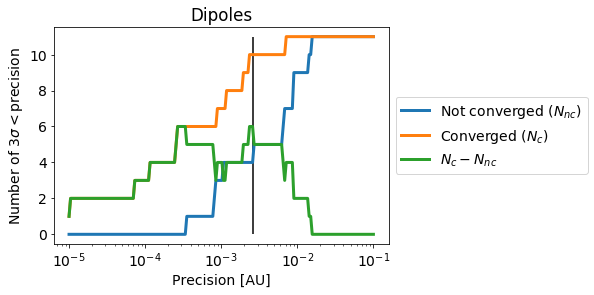

In [13]:
# Define a wide range of precisions
exponents = np.linspace(1, 5, 200)
precisions = [10**(-n) for n in exponents]
# Get the number of converged and non-converged dipoles below that
# precision
nb_c = [nb_under_3_std_dev(precision) for precision in precisions]
nb_nc = [
    nb_under_3_std_dev(precision, only_not_converged=True)
    for precision in precisions
]
# Compute the difference between both arrays
diff = np.array(nb_c)-np.array(nb_nc)
# Find the precision, associated with the largest difference
argmax = np.argmax(diff[::-1])
precision = precisions[::-1][argmax]
print(f"Precision: {precision:.2e} AU")
argmax = np.argmax(diff)
precision = precisions[argmax]
print(f"Precision: {precision:.2e} AU")
# Plot all the relevant data as a function of the precision
plt.plot(precisions, nb_nc, label=r"Not converged ($N_{nc}$)", lw=3)
plt.plot(precisions, nb_c, label=r"Converged ($N_{c}$)", lw=3)
plt.plot(precisions, diff, label=r"$N_c - N_{nc}$", lw=3)
plt.xscale('log')
plt.title("Dipoles")
plt.xlabel(r"Precision [AU]")
plt.ylabel(r"Number of $3 \sigma < $precision")
plt.vlines(precision, min(nb_nc), max(nb_c))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

Given that there are less data to be used (compared to the same study for phonon energies), there are two peaks for the difference between the number of converged and not converged dipoles under a given precision. The precision on the dipole might therefore span an order of magnitude, the largest value being 2.58 10$^{-3}$ AU.

## Plot the dispersion

The above cell shows that statistics such as the mean value and the standard deviation of each dipole can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged dipoles. Let us see how all these values can be used to do some plots, spanning the whole test set.

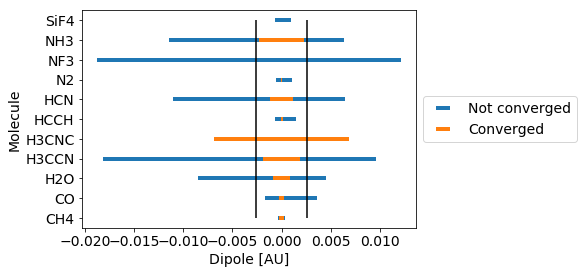

In [14]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    x_err = []  # Width of each error bar
    # Loop over the molecules
    for value in stats.values():
        # Define the width of the error-bar
        if not isinstance(value[key]["std_dev"], np.float64):
            x_err.append(0)
        else:    
            x_err.append(3*value[key]["std_dev"])
        # Define the center of the error-bar for non-converged results
        if key == "not_converged":
            converged_mean = value["converged"]["mean"]
            not_converged_mean = value["not_converged"]["mean"]
            if (not isinstance(converged_mean, np.float64) 
                    or not isinstance(not_converged_mean, np.float64)):
                x.append(0)
            else:
                x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Set the y-axis as an ID of the dipole
    y = np.arange(len(x_err))
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.yticks(y, [name for name in stats])
plt.xlabel("Dipole [AU]")
plt.ylabel("Molecule")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

This is the same plot as above, except that the y-axis gives the mean dipole for the converged calculations. It seems that large dipoles tend to give larger errors than the smaller ones.

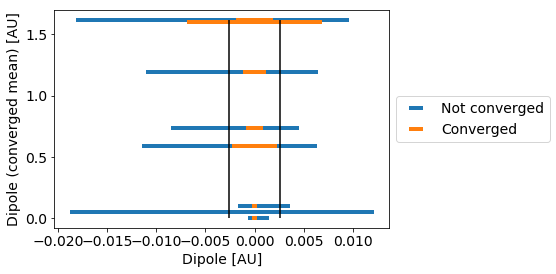

In [15]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    y = []  # Mean dipole of the converged calculations
    x_err = []  # Width of each error-bars along the x-axis
    # Loop over the molecules
    for value in stats.values():
        # Define the location on the y-axis
        converged_mean = value["converged"]["mean"]
        y.append(converged_mean)
        # Define the width of the error-bar
        if not isinstance(value[key]["std_dev"], np.float64):
            x_err.append(0)
        else:    
            x_err.append(3*value[key]["std_dev"])
        # Define the center of the error-bar for non-converged results
        if key == "not_converged":
            not_converged_mean = value["not_converged"]["mean"]
            if (not isinstance(converged_mean, np.float64) 
                    or not isinstance(not_converged_mean, np.float64)):
                x.append(0)
            else:
                x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("Dipole [AU]")
plt.ylabel("Dipole (converged mean) [AU]")
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.vlines([-precision, precision], min(y), max(y))
plt.show()